<h1> Stéganographie par LSB </h1>
<i>par Claudia Delgado et Mehdi Miah - Mars 2017</i>

# Plan 

# Import

In [1]:
from scipy import misc
import numpy as np
from PIL import Image
import time
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt

%matplotlib inline

# Preambule

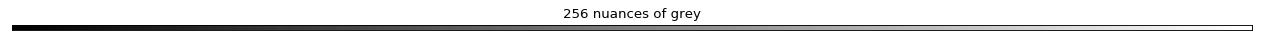

In [168]:
plt.figure(figsize = (20,20), dpi = 80)

plt.imshow(np.linspace(0, 255, 256).reshape((1,256)) , cmap=plt.cm.gray)
plt.title('256 nuances of grey')
plt.xticks([])
plt.yticks([])

plt.show()

Moving to the right means that the number incremented by one.
The `0` is on the far left and the `255` on the far right.

# Choices of images

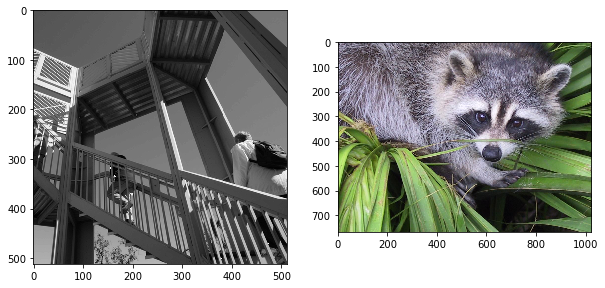

In [2]:
original_carrier = misc.ascent()
original_hidden = misc.face()

plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(original_carrier, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(original_hidden)

# Cleaning the images

In [3]:
# Shapes of images
print('The carrier image is', original_carrier.shape)
print('The hidden image is', original_hidden.shape)

The carrier image is (512, 512)
The hidden image is (768, 1024, 3)


In [4]:
# Test if the two inputs have the same size
if original_carrier.shape == original_hidden.shape:
    print('OK, the two inputs have the same dimensions.')
else:
    print('BEWARE, you have to trunc an image.')
    
# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

print('The best dimension size is %.f x %.f.' %(x_min , y_min))

BEWARE, you have to trunc an image.
The best dimension size is 512 x 512.


In [5]:
#Correction of the hidden image (ALAMANO)
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

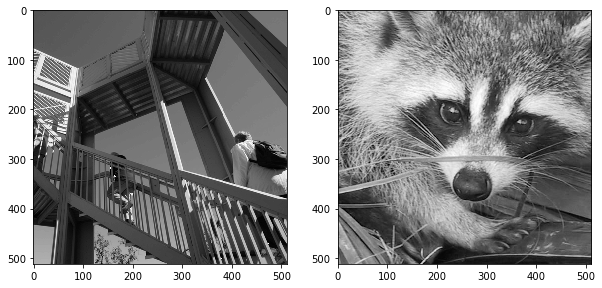

In [6]:
#Cleaned images (same dimensions)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier, cmap=plt.cm.gray)#, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(hidden, cmap=plt.cm.gray)#, interpolation="none")

In [7]:
#Sanity check
print(carrier.shape == hidden.shape)

True


# Functions to code and decode

In [8]:
def code_steganography_lsb(carrier, hidden, nb_hidden_bit=1):
    '''
    Input : carrier - number between 0 and 255 corresponding to the bit code of the carrier image
          : hidden - number between 0 and 255 corresponding to the bit code of the hidden image
          : nb_hidden_bit - the number of hidden bits
    Output : output - image resulting from the code      
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the carrier
    bin_carrier = format(carrier,'08b')

    #Binary of the hidden
    bin_hidden = format(hidden,'08b')

    #Result of the LSB algorithm
    bin_output = bin_carrier[:-nb_hidden_bit] + bin_hidden[:nb_hidden_bit-8]
    output = int(bin_output, 2)

    return output

In [9]:
def decode_steganography_lsb(output, nb_hidden_bit=1):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
          : nb_hidden_bit - the number of hidden bits
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the output
    bin_output = format(output,'08b')

    #Decode the binary code
    #for the carrier
    bin_carrier = bin_output[:8-nb_hidden_bit] + '0'*nb_hidden_bit
    carrier = int(bin_carrier , 2)

    #for the hidden
    bin_hidden = bin_output[-nb_hidden_bit:] + '0'*(8-nb_hidden_bit)
    hidden = int(bin_hidden , 2)

    return carrier, hidden

In [10]:
decode_steganography_lsb(89, nb_hidden_bit=5)

(64, 200)

In [11]:
def msb(image, nb_bits = 3):
    bin_image = format(image,'08b')
    bin_output = bin_image[:nb_bits] + '0'*(8-nb_bits)
    output = int(bin_output, 2)
    
    print(image, bin_image, bin_output, output)
    
    return(output)

In [12]:
msb(100, nb_bits = 1)

100 01100100 00000000 0


0

In [13]:
def lsb_to_msb(image, nb_bits = 3):
    '''
    Put the lsb of image to the msb of the output
    '''
    bin_image = format(image,'08b')
    bin_output = bin_image[-nb_bits:] + '0'*(8-nb_bits) 
    output = int(bin_output, 2)
    
    #print(image, bin_image, bin_output, output)
    
    return(output)

In [14]:
lsb_to_msb(100, nb_bits = 3)

128

# Application

## Encoding

In [27]:
%%time
#Encode
nb_hidden_bits_encode = 3
output = carrier.copy()
for i in range(carrier.shape[0]):
    for j in range(carrier.shape[1]):
        output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)

Wall time: 1.37 s


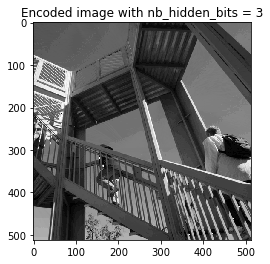

In [28]:
plt.imshow(output, cmap=plt.cm.gray)
plt.title('Encoded image with nb_hidden_bits = %.0f' %nb_hidden_bits_encode)

## Decoding knowing the hyperparameter

In [29]:
%%time
#Decode
nb_hidden_bits_decode = nb_hidden_bits_encode #the best hyperparameter
carrier_decode = output.copy()
hidden_decode = output.copy()
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)

Wall time: 1.3 s


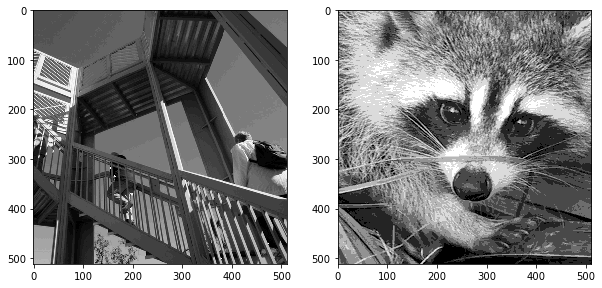

In [30]:
#Decodes images 
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier_decode, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(hidden_decode, cmap=plt.cm.gray)

Here, one knew that the optimal hyperparameter `nb_hidden_bits_decode`.
What happens if one does not know it ?

## Better choice of the hyperparameter `nb_hidden_bits_decode`

In [19]:
%%time

all_carrier_decode = []
all_hidden_decode = []

for nb_hidden_bits_decode in range(1,8):
    #Decode with different values of nb_hidden_bits_decode
    carrier_decode = output.copy()
    hidden_decode = output.copy()

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)
    all_carrier_decode.append(carrier_decode)
    all_hidden_decode.append(hidden_decode)

Wall time: 9.16 s


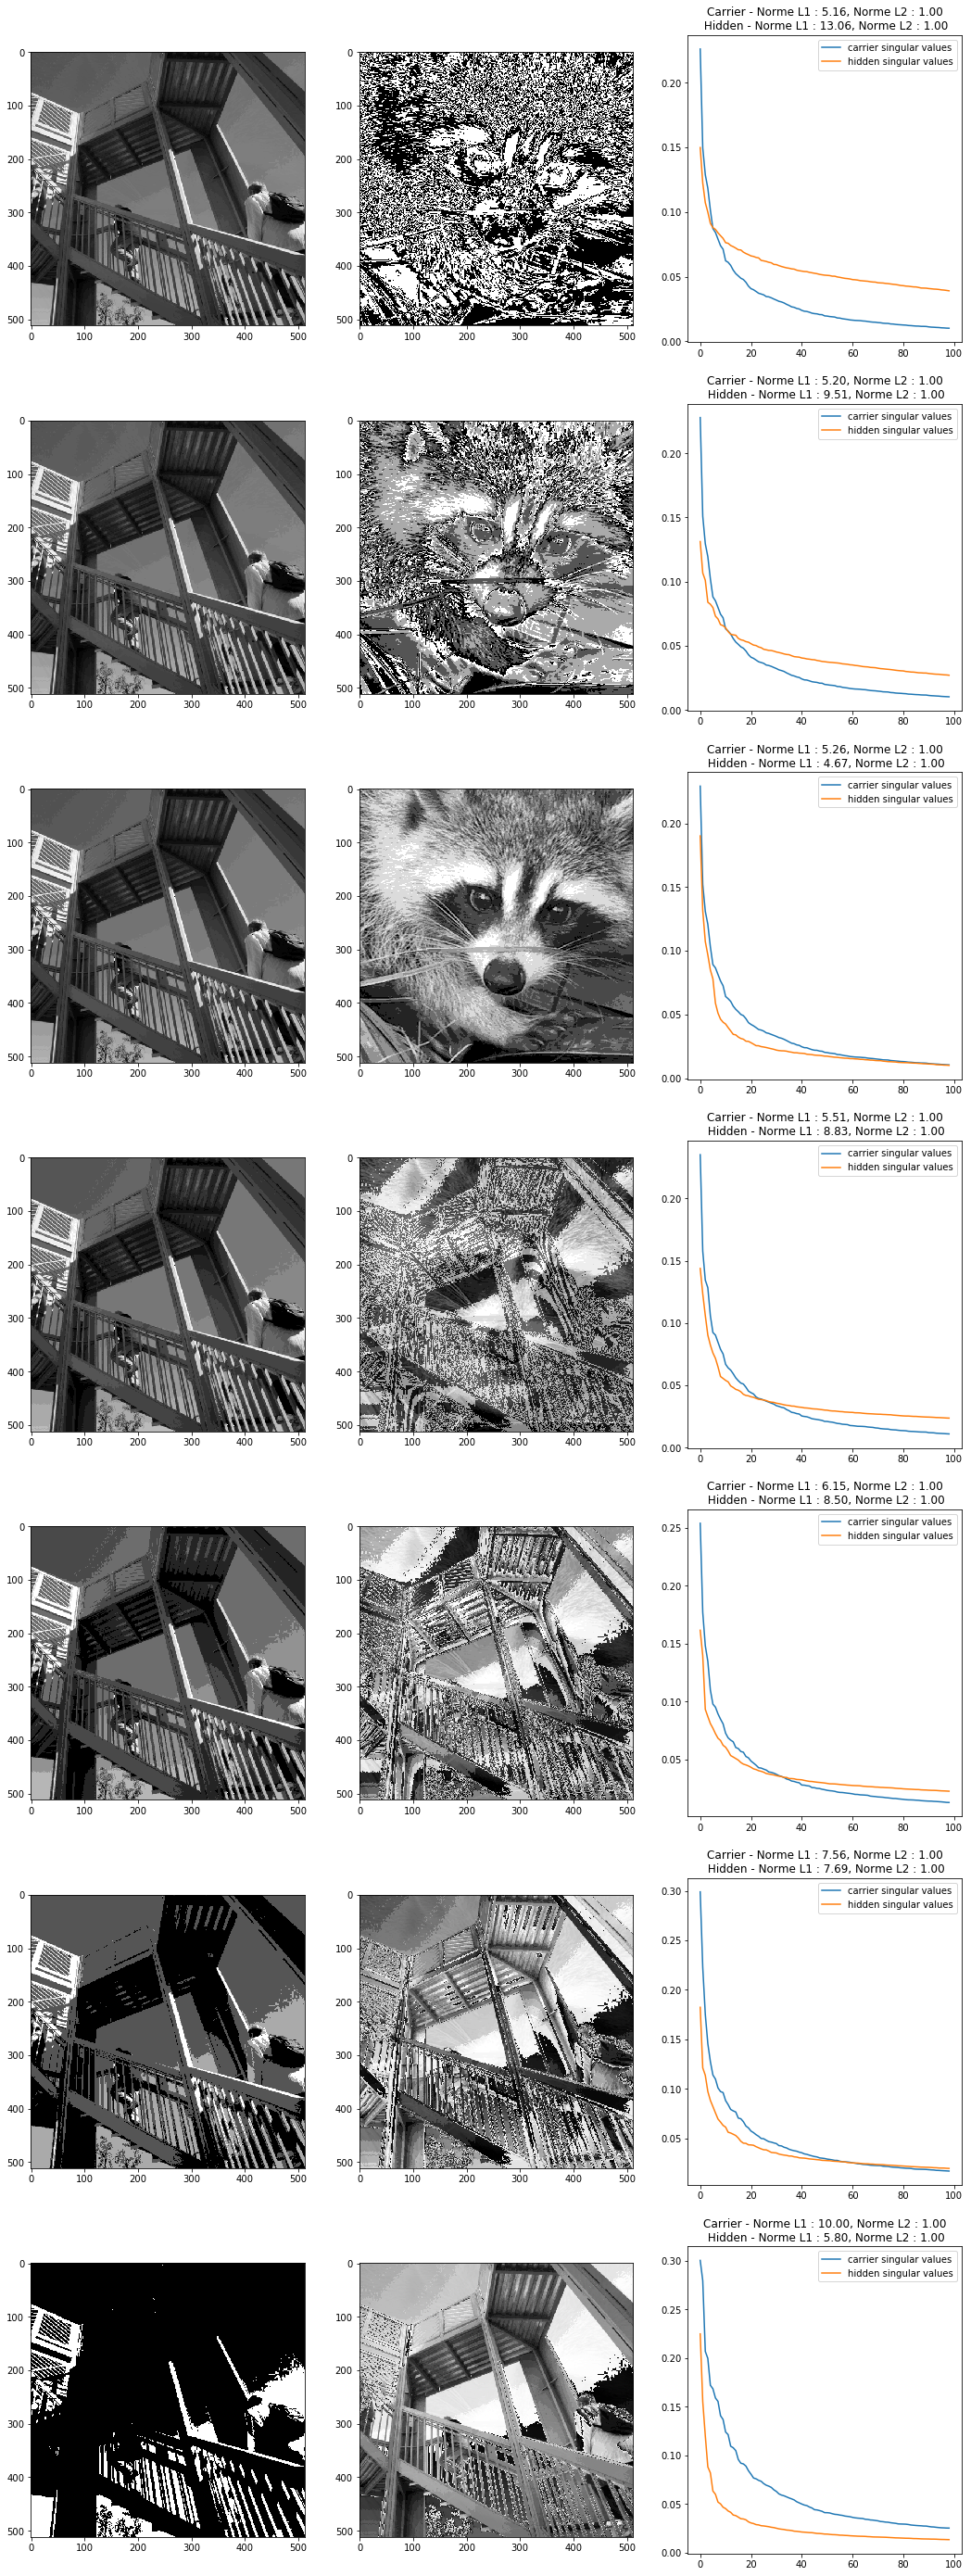

In [20]:
#Decoded images 
plt.figure(figsize = (18,50))
score_bit = []
score_carrier = []
score_hidden = []
for nb_hidden_bits_decode in range(0,7):
    plt.subplot(7,3,nb_hidden_bits_decode*3+1)
    plt.imshow(all_carrier_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)
    plt.subplot(7,3,nb_hidden_bits_decode*3+2)
    plt.imshow(all_hidden_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)
    
    Ucd, Scd, Vcd = svd(all_carrier_decode[nb_hidden_bits_decode])
    Uhd, Shd, Vhd = svd(all_hidden_decode[nb_hidden_bits_decode])
    Scd_normed = Scd/np.linalg.norm(Scd, 2)
    Shd_normed = Shd/np.linalg.norm(Shd, 2)
    plt.subplot(7,3,nb_hidden_bits_decode*3+3)
    plt.plot(Scd_normed[1:100], label = 'carrier singular values')
    plt.plot(Shd_normed[1:100], label = 'hidden singular values')
    plt.title('Carrier - Norme L1 : %.2f, Norme L2 : %.2f\n Hidden - Norme L1 : %.2f, Norme L2 : %.2f' 
              %(np.linalg.norm(Scd_normed,1), np.linalg.norm(Scd_normed, 2),
               np.linalg.norm(Shd_normed,1), np.linalg.norm(Shd_normed, 2)))
    plt.legend()
    
    score = (np.linalg.norm(Scd_normed,1) * np.linalg.norm(Shd_normed,1))
    score_bit.append(score)
    
    score_carrier.append(np.linalg.norm(Scd_normed,1))
    score_hidden.append(np.linalg.norm(Shd_normed,1))


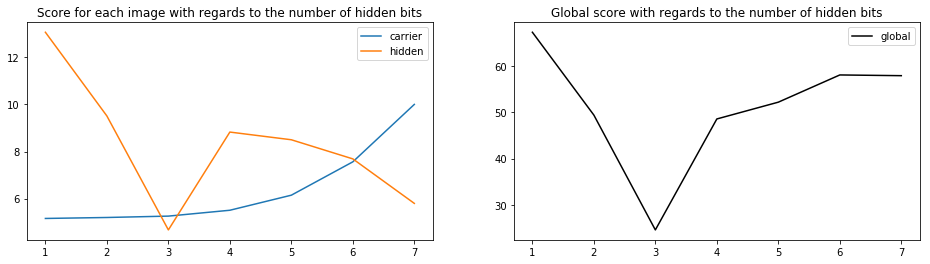

In [21]:
plt.figure(figsize = (16,4))

plt.subplot(1,2,1)
plt.plot(range(1,8), score_carrier, label = 'carrier')
plt.plot(range(1,8), score_hidden,label = 'hidden')
plt.title('Score for each image with regards to the number of hidden bits')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,8), score_bit, label = 'global', c = 'k')
plt.title('Global score with regards to the number of hidden bits')
plt.legend()

## Better choice of the hyperparameter `nb_hidden_bits_decode` (version without decoding)

In [39]:
%%time 
vector_norm_nuc = []

for nb_hidden_bits_decode in range(1,8):
    #take the lsb of the output to msb
    lsb_output = output.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            lsb_output[i,j] = lsb_to_msb(output[i,j], nb_bits = nb_hidden_bits_decode)
    
    norm_nuc = np.linalg.norm(lsb_output, 'nuc')
    
    vector_norm_nuc.append(norm_nuc)
    
    #plot the lsb image
    #plt.figure(figsize = (4,4))
    #plt.imshow(lsb_output, cmap=plt.cm.gray)
    #plt.title('Norm 1 : %.2f \t Norm 2 : %.2f' %(norm_1, norm_2))
    #plt.show()   

Wall time: 6.02 s


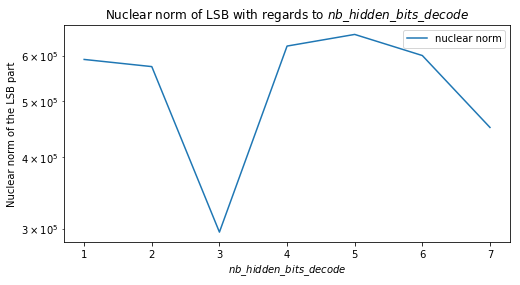

In [148]:
plt.figure(figsize = (8, 4))

plt.yscale('log')
plt.plot(range(1,8), vector_norm_nuc, label = 'nuclear norm')
plt.title(r'Nuclear norm of LSB with regards to $nb\_hidden\_bits\_decode$')
plt.xlabel('$nb\_hidden\_bits\_decode$')
plt.ylabel('Nuclear norm of the LSB part')
plt.legend()

plt.show()